# ver2 learn seccess ep_rew_mean26.8 -> 
# ver3 try action map 2227s with cpu no target_kl
# ver4 try gpu 740s 483fps 300_000timesteps(same as ver3)
# ver5 try gpu 6277s 487fps 3M timesteps still no learn
# ver6 try reward dist_ice gpu 22655s 443fps 10Mtimesteps still no learn
* pickup on factory when battery<0.1 -- later
* ice distance smaller when no cargo ice and battery>0.05
* dig on ice when cargo ice < cargo_cap and battery>0.05 -- later
## action_masks seems not working ##
# ver7 try mask cpu 747s 140fps 100_000timesteps seemed learned
* SB3Wrapper
* fixed action_masks
* move=False on ice when no cargo ice and battery>150
# ver8 gpu 14428s 419fps 6Mtimesteps no learn
* dist_ice rewards/300
## realized output must discrete action -> multidiscrete[12,12]##
# ver9 gpu 2fac no_mask 13976s 433fps 6Mtimesteps ep_rew_mean50.1
* no target_kl
# ver12 gpu from ver9best 7272s 421fps 3Mtimesteps ep_rew_mean17.3  wandb
## not seemed from best##
# ver 13 gpu from ver9best 10Mtimesteps wandb animate

This notebook builds up from the [this notebook](https://www.kaggle.com/code/cristojv/updated-rl-with-lux-invalid-action-masking), which trains a simple RL agent using invalid action masking. Rather than having a simple observation space that contains the position of of a single unit (a Heavy Robot), I want to codify the information of whole map. I based the observation space on the one used in [Gym-µRTS: Toward Affordable Full Game Real-time Strategy Games Research with Deep Reinforcement Learning](https://arxiv.org/pdf/2105.13807.pdf). More details about this new space will be given on the following sections.

In [ ]:
import shutil
shutil.make_archive('v9best', 'zip', '/kaggle/input/gymver9/logs/action_map/models/best_model/')

In [ ]:
import os
import wandb
# wandb.login()

In [ ]:
os.environ["WANDB_API_KEY"]='8b1bc318a40da8800d0980cb0c6b6350e2ee7566'

In [ ]:
from IPython.display import clear_output

!pip install gymnasium
import gymnasium
!pip install --upgrade luxai_s2
!pip install pettingzoo==1.12.0 stable-baselines3
!pip install --upgrade "importlib_metadata<5.0"
!pip install sb3_contrib
# !pip install optuna
clear_output()

In [ ]:
# %%writefile /opt/conda/lib/python3.7/site-packages/luxai_s2/version.py
# __version__ = ""
# this code above is used for Kaggle Notebooks
# You might not need to run this but if you get an attribute error about the gym package, run it

In [ ]:
import importlib
import importlib_metadata
# kaggle has 6.0.0 installed but we need version <5.0
importlib.reload(importlib_metadata)

Remember to ``"Restart & clear cell outputs"`` at this time

In [ ]:
# Common imports 
import numpy as np
import numpy.typing as npt
import torch as th
import torch.nn as nn
import matplotlib.pyplot as plt
import os.path as osp

from typing import Any, Dict, Callable, Optional

# LuxAI imports
from luxai_s2.env import LuxAI_S2
from lux.config import EnvConfig
from luxai_s2.state import ObservationStateDict
from luxai_s2.unit import UnitType, UnitStateDict, ActionType, BidActionType, FactoryPlacementActionType
from luxai_s2.utils import my_turn_to_place_factory
from luxai_s2.wrappers.controllers import Controller

# Gym imports
import gym as gym21
from gymnasium import spaces
from gymnasium import ActionWrapper, ObservationWrapper, RewardWrapper, Wrapper
from gymnasium.wrappers import TimeLimit

# SB3 imports
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecVideoRecorder
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

# SB3-contrib imports
from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy

As you can see from the previous imports we are going to use the **[stable-baselines3-contrib](https://github.com/Stable-Baselines-Team/stable-baselines3-contrib)** repo.

This is the **contrib** package for **Stable-Baselines3** - Experimental reinforcement learning (RL) code.

Remark that this package is experimental and currently does not support Multiprocessing (``SubprocVecEnv`` environments) issue [#49](https://github.com/Stable-Baselines-Team/stable-baselines3-contrib/issues/49). Although Multithreading is currently available.

I'm working on a potential fix for supporting multiprocessing to speed up the training time. I will update this notebook acordindly. You can see how can you fix it in the aforementioned issue link.

# Create a base environment

In [ ]:
env = LuxAI_S2() # Load environment
obs = env.reset(12412) # Reset environment -> first observation
board = obs['player_0']['board'] # Get board

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10,3))
ax[0].imshow(board['ice']) # Show ice
ax[0].set_title(f"ice: \n max: {np.max(board['ice'])}, min: {np.min(board['ice'])}")
ax[1].imshow(board['ore']) # Show ore
ax[1].set_title(f"ore: \n max: {np.max(board['ore'])}, min: {np.min(board['ore'])}")
ax[2].imshow(board['rubble']) # Show rubble
ax[2].set_title(f"rubble: \n max: {np.max(board['rubble'])}, min: {np.min(board['rubble'])}")
ax[3].imshow(np.stack([board['ore'],board['ice'],board['rubble']/100],axis=2))

plt.show()

# Single Environment training

The base notebook focuses on training a single HEAVY robot unit to gather resources. We will do the same here but including action masking.

## 1. Simplifying the action space.

Fist we defined an action controller that will: (i) set up a simplified action space (for one robot), (ii) translate actions from the simplified action space to the base action space, (iii) generate action masks, (iv) the heuristic policies for the factory to build one robot ASAP.

For reference check [StoneTao's](https://www.kaggle.com/code/stonet2000/rl-with-lux-2-rl-problem-solving) notebook and give him an upvote.

In [ ]:
# Controller class copied here since you won't have access to the luxai_s2 package directly on the competition server
class Controller:
    def __init__(self, action_space: spaces.Space) -> None:
        self.action_space = action_space

    def action_to_lux_action(self, agent: str, obs: Dict[str, Any], action: npt.NDArray):
        """
        Takes as input the current "raw observation" and the parameterized action and returns
        an action formatted for the Lux env
        """
        raise NotImplementedError()

    def get_action_masks(self, agent: str, obs: Dict[str, Any]):
        """
        Generates a boolean action mask indicating in each discrete dimension whether it would be valid or not
        """
        raise NotImplementedError()

In [ ]:
class SimpleUnitDiscreteController(Controller):
    def __init__(self, env_cfg) -> None:
        """
        A simple controller that controls only the robot that will get spawned.
        Moreover, it will always try to spawn one heavy robot if there are none regardless of action given

        For the robot unit
        - 4 cardinal direction movement (4 dims)
        - a move center no-op action (1 dim)
        - transfer action just for transferring ice in 4 cardinal directions or center (5)
        - pickup action for power (1 dims)
        - dig action (1 dim)
        - no op action (1 dim) - equivalent to not submitting an action queue which costs power

        It does not include
        - self destruct action
        - recharge action
        - planning (via actions executing multiple times or repeating actions)
        - factory actions
        - transferring power or resources other than ice

        To help understand how to this controller works to map one action space to the original lux action space,
        see how the lux action space is defined in luxai_s2/spaces/action.py

        """
        self.env_cfg = env_cfg
        self.move_act_dims = 4
        self.transfer_act_dims = 5
        self.pickup_act_dims = 1
        self.dig_act_dims = 1
        self.no_op_dims = 1

        self.move_dim_high = self.move_act_dims
        self.transfer_dim_high = self.move_dim_high + self.transfer_act_dims
        self.pickup_dim_high = self.transfer_dim_high + self.pickup_act_dims
        self.dig_dim_high = self.pickup_dim_high + self.dig_act_dims
        self.no_op_dim_high = self.dig_dim_high + self.no_op_dims

        self.total_act_dims = self.no_op_dim_high
#         action_space = spaces.Discrete(self.total_act_dims)
        action_space = spaces.MultiDiscrete([12,12])
        super().__init__(action_space)

    def _is_move_action(self, id):
        return id < self.move_dim_high

    def _get_move_action(self, id):
        # move direction is id + 1 since we don't allow move center here
        return np.array([0, id + 1, 0, 0, 0, 1])

    def _is_transfer_action(self, id):
        return id < self.transfer_dim_high

    def _get_transfer_action(self, id):
        id = id - self.move_dim_high
        transfer_dir = id % 5
        return np.array([1, transfer_dir, 0, self.env_cfg.max_transfer_amount, 0, 1])

    def _is_pickup_action(self, id):
        return id < self.pickup_dim_high

    def _get_pickup_action(self, id):
        return np.array([2, 0, 4, self.env_cfg.max_transfer_amount, 0, 1])

    def _is_dig_action(self, id):
        return id < self.dig_dim_high

    def _get_dig_action(self, id):
        return np.array([3, 0, 0, 0, 0, 1])

    def action_to_lux_action(
        self, agent: str, obs: Dict[str, Any], action: npt.NDArray
    ):
        shared_obs = obs[agent]
        lux_action = dict()
        units = shared_obs["units"][agent]
        for i,unit_id in enumerate(units.keys()):
            unit = units[unit_id]
#             print(self.action_masks(agent=agent,obs=obs))
#             print(action[:,unit['pos'][0],unit['pos'][1]])
#             masked = self.action_masks(agent=agent,obs=obs)*action[:,unit['pos'][0],unit['pos'][1]]
#             masked[masked==0] = -1
#             print('masked',masked)
#             choice = np.argmax(masked)
#             print('choice',choice)
            choice = action[i]
            action_queue = []
            no_op = False
            if self._is_move_action(choice):
                action_queue = [self._get_move_action(choice)]
            elif self._is_transfer_action(choice):
                action_queue = [self._get_transfer_action(choice)]
            elif self._is_pickup_action(choice):
                action_queue = [self._get_pickup_action(choice)]
            elif self._is_dig_action(choice):
                action_queue = [self._get_dig_action(choice)]
            else:
                # action is a no_op, so we don't update the action queue
                no_op = True

            # simple trick to help agents conserve power is to avoid updating the action queue
            # if the agent was previously trying to do that particular action already
            if len(unit["action_queue"]) > 0 and len(action_queue) > 0:
                same_actions = (unit["action_queue"][0] == action_queue[0]).all()
                if same_actions:
                    no_op = True
            if not no_op:
                lux_action[unit_id] = action_queue

#             break

        factories = shared_obs["factories"][agent]
        if len(units) <= 1:
            for unit_id in factories.keys():
                lux_action[unit_id] = 1  # build a single heavy
#         print('lux_action', agent, lux_action)
        return lux_action

    def action_masks(self, agent: str, obs: Dict[str, Any]):
        """
        Defines a simplified action mask for this controller's action space

        Doesn't account for whether robot has enough power
        """

        # compute a factory occupancy map that will be useful for checking if a board tile
        # has a factory and which team's factory it is.
        shared_obs = obs[agent]
        factory_occupancy_map = (
            np.ones_like(shared_obs["board"]["rubble"], dtype=int) * -1
        )
        factories = dict()
        for player in shared_obs["factories"]:
            factories[player] = dict()
            for unit_id in shared_obs["factories"][player]:
                f_data = shared_obs["factories"][player][unit_id]
                f_pos = f_data["pos"]
                # store in a 3x3 space around the factory position it's strain id.
                factory_occupancy_map[
                    f_pos[0] - 1 : f_pos[0] + 2, f_pos[1] - 1 : f_pos[1] + 2
                ] = f_data["strain_id"]

        units = shared_obs["units"][agent]
#         print(units)
        action_masks = np.zeros((2,self.total_act_dims), dtype=bool)
        for j, (unit_id, unit) in enumerate(units.items()):
            action_mask = np.zeros(self.total_act_dims)
            # movement is always valid
            action_mask[:4] = True
            
            
            ice_map = shared_obs['board']['ice']
            if ice_map[unit['pos'][0],unit['pos'][1]]==1 and unit['cargo']['ice']==0 and unit['power']>150:
                action_mask[:4] = False

            # transferring is valid only if the target exists
            unit = units[unit_id]
            pos = np.array(unit["pos"])
            # a[1] = direction (0 = center, 1 = up, 2 = right, 3 = down, 4 = left)
            move_deltas = np.array([[0, 0], [0, -1], [1, 0], [0, 1], [-1, 0]])
            for i, move_delta in enumerate(move_deltas):
                transfer_pos = np.array(
                    [pos[0] + move_delta[0], pos[1] + move_delta[1]]
                )
                # check if theres a factory tile there
                if (
                    transfer_pos[0] < 0
                    or transfer_pos[1] < 0
                    or transfer_pos[0] >= len(factory_occupancy_map)
                    or transfer_pos[1] >= len(factory_occupancy_map[0])
                ):
                    continue
                factory_there = factory_occupancy_map[transfer_pos[0], transfer_pos[1]]
                if factory_there in shared_obs["teams"][agent]["factory_strains"]:
                    action_mask[
                        self.transfer_dim_high - self.transfer_act_dims + i
                    ] = True

            factory_there = factory_occupancy_map[pos[0], pos[1]]
            on_top_of_factory = (
                factory_there in shared_obs["teams"][agent]["factory_strains"]
            )

            # dig is valid only if on top of tile with rubble or resources or lichen
            board_sum = (
                shared_obs["board"]["ice"][pos[0], pos[1]]
                + shared_obs["board"]["ore"][pos[0], pos[1]]
                + shared_obs["board"]["rubble"][pos[0], pos[1]]
                + shared_obs["board"]["lichen"][pos[0], pos[1]]
            )
            if board_sum > 0 and not on_top_of_factory:
                action_mask[
                    self.dig_dim_high - self.dig_act_dims : self.dig_dim_high
                ] = True

            # pickup is valid only if on top of factory tile
            if on_top_of_factory:
                action_mask[
                    self.pickup_dim_high - self.pickup_act_dims : self.pickup_dim_high
                ] = True
                action_mask[
                    self.dig_dim_high - self.dig_act_dims : self.dig_dim_high
                ] = False

            # no-op is always valid
            action_mask[-1] = True
            action_masks[j,:] = action_mask
#             if np.sum(action_masks)==0:
#                 action_masks = action_mask
#             else:
#                 action_masks = np.concatenate((action_masks, action_mask), axis=0)
#         print(agent, action_masks)
#             break
        return np.array(action_masks, dtype=bool).flatten()

## 2. Creating the observation space.

Instead of using ``ObservationWrapper``, which only has information about the single Heavy Robot unit spawned, we will use a new observation space named `RTSObservationWrapper`. Unlike the former, this new space can contain information about all the units contained in the map. The unit space has a shape of
(map_size, map_size, 13). For a single pixel of the map, a 13 vector component will encode the information about the units that are placed in such pixel.

This 13-dimensional vector is composed of:

- 2 dimensions that encode the unit type. Since only one Heavy Robot unit is spawned, only two types are considered. The two dimensions encode the following information:
  - \[0, 0\]: No unit is present
  - \[1, 0\]: A factory unit is present
  - \[0, 1\]: A Heavy Robot unit is present
  - \[1, 1\]: A Factory and a Heavy Robot unit are present
- 10 dimensions that encode in binary the ice in the Heavy Robot's  cargo. For example, [0 ,0 ,0, 0, 0, 0, 0, 0, 1, 1] means that the Heavy Unit contains
2^1 + 2^0 ice units, 3 units in total.
- 1 dimensions that indicates if the map pixel contains ice. 

In [ ]:
# def bin_array(num, m):
#     """Convert a positive integer num into an m-bit bit vector"""
#     return np.array(list(np.binary_repr(num).zfill(m))).astype(np.int8)


class RTSObservationWrapper(gymnasium.ObservationWrapper):
    """Each agent just sees its own factories and units.

    Unit type 2 (factory, heavy, noop)
    Cargo Ice: 10 (heavy) 2**10 
        cargo/cargomax
    Resources: 1 (ice)

    For example, a cell where a factory and a heavy robot is located,
    robot has 1 ice and the cell has no ice:

    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ]

    """

    def __init__(self, env: gymnasium.Env) -> None:
        super().__init__(env)
        self.observation_space = spaces.Box(
            0, 1, shape=(5, env.env_cfg.map_size, env.env_cfg.map_size),# dtype=np.int8
        )

    def observation(self, obs):
        return RTSObservationWrapper.convert_obs(obs, self.env.state.env_cfg)

    # we make this method static so the submission/evaluation code can use this as well
    @staticmethod
    def convert_obs(obs: Dict[str, Any], env_cfg: Any) -> Dict[str, npt.NDArray]:
        observation = dict()
        shared_obs = obs["player_0"]

        ice_map = np.array(shared_obs["board"]["ice"], dtype=int)
        ice_map = np.expand_dims(ice_map, axis=0)

        ice_cargo = np.zeros((1, env_cfg.map_size, env_cfg.map_size))
        battery = np.zeros((1, env_cfg.map_size, env_cfg.map_size))

        for agent in obs.keys():
            factory_location = np.zeros(
                shape=(1, env_cfg.map_size, env_cfg.map_size), dtype=np.int8
            )
            unit_location = np.zeros(
                shape=(1, env_cfg.map_size, env_cfg.map_size), dtype=np.int8
            )

            factories = shared_obs["factories"]['player_0']

            for k in factories.keys():
                factory = factories[k]
                fac_x, fac_y = factory["pos"]
                factory_location[:, fac_x-1:fac_x+2, fac_y-1:fac_y+2] = 1

            units = shared_obs["units"][agent]
            for k in units.keys():
                unit = units[k]
                unit_pos_x, unit_pos_y = unit["pos"]

                unit_location[:, unit_pos_x, unit_pos_y] = 1

#                 unit_ice_cargo = int(unit["cargo"]["ice"])

#                 ice_cargo[:, unit_pos_x, unit_pos_y] = bin_array(
#                     unit_ice_cargo, ice_cargo.shape[0]
#                 )
                cargo_space = env_cfg.ROBOTS[unit["unit_type"]].CARGO_SPACE
                battery_cap = env_cfg.ROBOTS[unit["unit_type"]].BATTERY_CAPACITY

                battery[:, unit_pos_x, unit_pos_y] = unit["power"] / battery_cap,
                ice_cargo[:, unit_pos_x, unit_pos_y] = unit["cargo"]["ice"] / cargo_space,

            agent_observation = np.concatenate(
                [factory_location, unit_location, ice_map, ice_cargo, battery],
                axis=0,
            )

            observation[agent] = agent_observation

        return observation


# Invalid Action Masking

To perform the invalid action masking we are going to use the ``MaskablePPO`` class implemented in sb3-contrib package.

From the sb3-contrib [documentation](https://sb3-contrib.readthedocs.io/en/master/modules/ppo_mask.html).

**Maskable PPO**

Implementation of invalid action masking for the Proximal Policy Optimization (PPO) algorithm. Other than adding support for action masking, the behavior is the same as in SB3’s core PPO algorithm.

Train a **Maskable PPO** agent requires that the environment has an ``action_masks`` method that returns the invalid action mask. 

For this purpose we extend the``SB3Wrapper`` with the class ``SB3InvalidActionWrapper`` with the corresponding ``action_masks`` method.

In [ ]:
class SB3Wrapper(gymnasium.Wrapper):
    def __init__(
        self,
        env: LuxAI_S2,
        bid_policy: Callable[
            [str, ObservationStateDict], Dict[str, BidActionType]
        ] = None,
        factory_placement_policy: Callable[
            [str, ObservationStateDict], Dict[str, FactoryPlacementActionType]
        ] = None,
        controller: Controller = None,
    ) -> None:
        """
        A environment wrapper for Stable Baselines 3. It reduces the LuxAI_S2 env
        into a single phase game and places the first two phases (bidding and factory placement) into the env.reset function so that
        interacting agents directly start generating actions to play the third phase of the game.

        It also accepts a Controller that translates action's in one action space to a Lux S2 compatible action

        Parameters
        ----------
        bid_policy: Function
            A function accepting player: str and obs: ObservationStateDict as input that returns a bid action
            such as dict(bid=10, faction="AlphaStrike"). By default will bid 0
        factory_placement_policy: Function
            A function accepting player: str and obs: ObservationStateDict as input that returns a factory placement action
            such as dict(spawn=np.array([2, 4]), metal=150, water=150). By default will spawn in a random valid location with metal=150, water=150
        controller : Controller
            A controller that parameterizes the action space into something more usable and converts parameterized actions to lux actions.
            See luxai_s2/wrappers/controllers.py for available controllers and how to make your own
        """
        gymnasium.Wrapper.__init__(self, env)
        self.env = env
        
        assert controller is not None
        
        # set our controller and replace the action space
        self.controller = controller
        self.action_space = controller.action_space

        # The simplified wrapper removes the first two phases of the game by using predefined policies (trained or heuristic)
        # to handle those two phases during each reset
        if factory_placement_policy is None:
            def factory_placement_policy(player, obs: ObservationStateDict):
                potential_spawns = np.array(
                    list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1)))
                )
                spawn_loc = potential_spawns[
                    np.random.randint(0, len(potential_spawns))
                ]
                return dict(spawn=spawn_loc, metal=150, water=150)

        self.factory_placement_policy = factory_placement_policy
        if bid_policy is None:
            def bid_policy(player, obs: ObservationStateDict):
                faction = "AlphaStrike"
                if player == "player_1":
                    faction = "MotherMars"
                return dict(bid=0, faction=faction)

        self.bid_policy = bid_policy

        self.prev_obs = None

    def step(self, action: Dict[str, npt.NDArray]):
        
        # here, for each agent in the game we translate their action into a Lux S2 action
        lux_action = dict()
        for agent in self.env.agents:
            if agent in action:
                lux_action[agent] = self.controller.action_to_lux_action(
                    agent=agent, obs=self.prev_obs, action=action[agent]
                )
            else:
                lux_action[agent] = dict()
        
        # lux_action is now a dict mapping agent name to an action
        obs, reward, done, info = self.env.step(lux_action)
        self.prev_obs = obs
#         print('lux_action',lux_action)
        return obs, reward, done, done, info
    
    def render(self, render_mode='rgb_array'):
#         return self.env.render('rgb_array')
        return self.env.render(mode=render_mode)

    def reset(self, **kwargs):
        # we upgrade the reset function here
        
        # we call the original reset function first
        del kwargs['options']
        obs = self.env.reset(**kwargs)
        
        # then use the bid policy to go through the bidding phase
        action = dict()
        for agent in self.env.agents:
            action[agent] = self.bid_policy(agent, obs[agent])
        obs, _, _, _ = self.env.step(action)
#         print(obs['player_0']['board']['rubble'][0][47])
        
        # while real_env_steps < 0, we are in the factory placement phase
        # so we use the factory placement policy to step through this
        while self.env.state.real_env_steps < 0:
            action = dict()
            for agent in self.env.agents:
                if my_turn_to_place_factory(
                    obs["player_0"]["teams"][agent]["place_first"],
                    self.env.state.env_steps,
                ):
                    action[agent] = self.factory_placement_policy(agent, obs[agent])
                else:
                    action[agent] = dict()
            obs, _, _, _ = self.env.step(action)
        self.prev_obs = obs
        
        return obs, 0

In [ ]:
# from luxai_s2.wrappers import SB3Wrapper

# class SB3InvalidActionWrapper(SB3Wrapper):
#     def __init__(
#         self,
#         env: LuxAI_S2,
#         bid_policy: Callable[
#             [str, ObservationStateDict], Dict[str, BidActionType]
#         ] = None,
#         factory_placement_policy: Callable[
#             [str, ObservationStateDict], Dict[str, FactoryPlacementActionType]
#         ] = None,
#         controller: Controller = None,
#     ) -> None:
#         super().__init__(env, bid_policy, factory_placement_policy, controller)
    
#     def action_masks(self):
#         return self.controller.action_masks('player_0', self.prev_obs)

class CustomEnvWrapper(gymnasium.Wrapper):
    def __init__(self, env: gymnasium.Env) -> None:
        """
        Adds a custom reward and turns the LuxAI_S2 environment into a single-agent environment for easy training
        """
        super().__init__(env)
        self.prev_step_metrics = None

    def step(self, action):
        agent = "player_0"
        opp_agent = "player_1"

#         ice_map = self.env.state.board.ice
#         ice_tile_locations = np.argwhere(ice_map == 1)

#         units = self.env.state.units[agent]
#         min_ice_tile_distances = 0
#         for k in units.keys():
#             unit = units[k]
#             min_ice_tile_distances = np.min(
#                     (ice_tile_locations - np.array(unit_pos)) ** 2, 1
#                 )
#         print('min_ice_tile_distances', min_ice_tile_distances)
#         factories = self.env.state.factories[agent]
#         for k in factories.keys():
#             factory = factories[k]
        

        
        opp_factories = self.env.state.factories[opp_agent]
        for k in opp_factories.keys():
            factory = opp_factories[k]
            # set enemy factories to have 1000 water to keep them alive the whole around and treat the game as single-agent
            factory.cargo.water = 1000

        # submit actions for just one agent to make it single-agent
        # and save single-agent versions of the data below
        action = {agent: action}
        obs, _, terminated, truncated, info = self.env.step(action)
        obs = obs[agent]
        '''
        agent_observation = np.concatenate(
                [factory_location, unit_location, ice_map, ice_cargo, battery],
                axis=0,
            ) 
        '''
#         fac_loc = np.argwhere(obs[0]==1)
#         unit_loc = np.argwhere(obs[1]==1)[0]
#         ice_cargo = obs[3,unit_loc[0],unit_loc[1]]
#         battery = obs[4,unit_loc[0],unit_loc[1]]
        terminated = terminated[agent]
        truncated = truncated[agent]

        # we collect stats on teams here. These are useful stats that can be used to help generate reward functions
        stats: StatsStateDict = self.env.state.stats[agent]
#         print(stats)

### new reward
# pickup on factory when battery<0.1 -- later
# ice distance smaller when no cargo ice and battery>0.05 
# dig on ice when cargo ice < cargo_cap and battery>0.05 -- later
#         for unit_id in obs['units']

        info = dict()
        metrics = dict()
#         metrics['dist_ice']= min(np.mean((ice_tile_locations - unit_loc) ** 2, 1))

        metrics["ice_dug"] = (
            stats["generation"]["ice"]["HEAVY"] + stats["generation"]["ice"]["LIGHT"]
        )
        metrics["water_produced"] = stats["generation"]["water"]

        # we save these two to see often the agent updates robot action queues and how often enough
        # power to do so and succeed (less frequent updates = more power is saved)
        metrics["action_queue_updates_success"] = stats["action_queue_updates_success"]
        metrics["action_queue_updates_total"] = stats["action_queue_updates_total"]

        # we can save the metrics to info so we can use tensorboard to log them to get a glimpse into how our agent is behaving
        info["metrics"] = metrics

        reward = 0
        if self.prev_step_metrics is not None:
            # we check how much ice and water is produced and reward the agent for generating both
            ice_dug_this_step = metrics["ice_dug"] - self.prev_step_metrics["ice_dug"]
            water_produced_this_step = (
                metrics["water_produced"] - self.prev_step_metrics["water_produced"]
            )
#             to_ice_this_step = 0
#             if ice_cargo == 0 and battery > 0.05:
#                 to_ice_this_step = self.prev_step_metrics['dist_ice'] - metrics['dist_ice']
            
            # we reward water production more as it is the most important resource for survival
            reward = ice_dug_this_step / 100 + water_produced_this_step# + to_ice_this_step / 300

        self.prev_step_metrics = copy.deepcopy(metrics)
        return obs, reward, terminated, truncated, info

    def reset(self, **kwargs):
        obs,_ = self.env.reset(**kwargs)#["player_0"]
        obs = obs['player_0']
        self.prev_step_metrics = None
        return obs, _

### Defining a Bid, Factory Placement, and Factory Build

To test the code above, we can program some heuristic bid and factory placement policies

In [ ]:
def zero_bid(player, obs):
    # a policy that always bids 0
    faction = "AlphaStrike"
    if player == "player_1":
        faction = "MotherMars"
    return dict(bid=0, faction=faction)

def place_near_random_ice(player, obs):
    """
    This policy will place a single factory with all the starting resources
    near a random ice tile
    """
    if obs["teams"][player]["metal"] == 0:
        return dict()
    potential_spawns = list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1)))
    potential_spawns_set = set(potential_spawns)
    done_search = False
    
    # simple numpy trick to find locations adjacent to ice tiles.
    ice_diff = np.diff(obs["board"]["ice"])
    pot_ice_spots = np.argwhere(ice_diff == 1)
    if len(pot_ice_spots) == 0:
        pot_ice_spots = potential_spawns
    
    # pick a random ice spot and search around it for spawnable locations.
    trials = 5
    while trials > 0:
        pos_idx = np.random.randint(0, len(pot_ice_spots))
        pos = pot_ice_spots[pos_idx]
        area = 3
        for x in range(area):
            for y in range(area):
                check_pos = [pos[0] + x - area // 2, pos[1] + y - area // 2]
                if tuple(check_pos) in potential_spawns_set:
                    done_search = True
                    pos = check_pos
                    break
            if done_search:
                break
        if done_search:
            break
        trials -= 1
    
    if not done_search:
        spawn_loc = potential_spawns[np.random.randint(0, len(potential_spawns))]
        pos = spawn_loc
    # this will spawn a factory at pos and with all the starting metal and water
    metal = obs["teams"][player]["metal"]
    return dict(spawn=pos, metal=100, water=100)

def factory_build_heavy_robot_policy(obs, agent):
    for factory_id in obs[agent]['factories'][agent]:
        if len(obs[agent]['units'][agent]) == 0:
            return {factory_id : 1}
    return {}

In [ ]:
def make_env(env_id: str, rank: int, seed: int = 0, max_episode_steps=100, render_mode='rgb_array'):
    def _init() -> gymnasium.Env:
        # verbose = 0
        # collect stats so we can create reward functions
        # max factories set to 2 for simplification and keeping returns consistent as we survive longer if there are more initial resources
        env = gym21.make(env_id, verbose=0, collect_stats=True, MAX_FACTORIES=2)

        # Add a SB3 wrapper to make it work with SB3 and simplify the action space with the controller
        # this will remove the bidding phase and factory placement phase. For factory placement we use
        # the provided place_near_random_ice function which will randomly select an ice tile and place a factory near it.

#         env = SB3InvalidActionWrapper(
        env = SB3Wrapper(
            env,
            factory_placement_policy=place_near_random_ice,
            controller=SimpleUnitDiscreteController(env.env_cfg),
        )
        env = RTSObservationWrapper(
            env
        )  # changes observation to include a few simple features
        env = CustomEnvWrapper(env)  # convert to single agent, add our reward
        env = TimeLimit(
            env, max_episode_steps=max_episode_steps
        )  # set horizon to 100 to make training faster. Default is 1000
        env = Monitor(env)  # for SB3 to allow it to record metrics
        env.reset(seed=seed + rank)
        set_random_seed(seed)
        return env

    return _init

# Training the agent

In [ ]:
def animate(imgs, video_name=None, _return=True):
    # using cv2 to generate videos
    import cv2
    import os
    import string
    import random
    video_name = video_name if video_name is not None else ''.join(random.choice(string.ascii_letters) for i in range(18))+'.webm'
    height, width, layers = imgs[0].shape
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'VP80'), 20, (width,height))
    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()
    if _return:
        from IPython.display import Video
        return Video(video_name)

In [ ]:
import copy
env = make_env("LuxAI_S2-v0", 0, 0, max_episode_steps=200, render_mode='human')()
obs = env.reset() # always reset before starting a new episode!
imgs = []
for i in range(40):
    action = env.action_space.sample() # sample a random action
    obs, reward, terminated, truncated, info = env.step(action) # get the new observation and reward
    imgs += [env.render()] # save to video
    if terminated or truncated: env.reset()
env.close() # close the display window and free up resources
animate(imgs, "random_interaction.webm") # generate the video replay

In [ ]:
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
class TensorboardCallback(BaseCallback):
    def __init__(self, tag: str, verbose=0):
        super().__init__(verbose)
        self.tag = tag

    def _on_step(self) -> bool:
        c = 0

        for i, done in enumerate(self.locals["dones"]):
            if done:
                info = self.locals["infos"][i]
                c += 1
                for k in info["metrics"]:
                    stat = info["metrics"][k]
                    self.logger.record_mean(f"{self.tag}/{k}", stat)
        return True

## 4. Training Setup

Now we can prepare for training by creating training and evaluation environments, as well as defining our algorithm and model.

To train new observation space with shape (map_size, map_size, 13), a new policy network will be used. Concretely, for our future extractor, the`NatureCNN` network. For the `net_arch`, two dense layers with 64 units and tanh activation will be used.

![](https://stable-baselines3.readthedocs.io/en/master/_images/net_arch.png)

In [ ]:
class NatureCNN(BaseFeaturesExtractor):
    """
    CNN from DQN Nature paper:
        Mnih, Volodymyr, et al.
        "Human-level control through deep reinforcement learning."
        Nature 518.7540 (2015): 529-533.
    :param observation_space:
    :param features_dim: Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(
        self,
        observation_space: spaces.Box,
        features_dim: int = 512,
    ) -> None:
        super().__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))
    
policy_kwargs = dict(
    features_extractor_class=NatureCNN,
    features_extractor_kwargs=dict(features_dim=128),
    net_arch=(64, 64),
)

In [ ]:
from sb3_contrib import MaskablePPO
from stable_baselines3.ppo import PPO
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy

set_random_seed(42)
env_id = 'LuxAI_S2-v0'
log_path = "logs/action_map"
n_envs = 4

# set max episode steps to 200 for training environments to train faster
train_max_episode_steps=200
eval_max_episode_steps=200

# set Invalid action masking approach
invalid_action_masking=False

# CAUTION: MaskablePPO only works with DummyVecEnv.
# To implement multiprocessing using SubprocEnv, there is a current issue in GitHub at 
# https://github.com/Stable-Baselines-Team/stable-baselines3-contrib/issues/49

environments = [make_env(env_id, i, max_episode_steps=train_max_episode_steps) for i in range(n_envs)]
env = DummyVecEnv(environments) if invalid_action_masking else DummyVecEnv(environments)
# env = VecVideoRecorder(env, f"videos/{run.id}", render_mode='rgb_array', record_video_trigger=lambda x: x % 2000 == 0, video_length=200)

env.reset()

# set max episode steps to 1000 to match original environment
eval_environments = [make_env(env_id, i, max_episode_steps=eval_max_episode_steps) for i in range(4)]
eval_env = DummyVecEnv(eval_environments) if invalid_action_masking else DummyVecEnv(eval_environments)
# eval_env = VecVideoRecorder(eval_env, f"videos/{run.id}", render_mode='rgb_array', record_video_trigger=lambda x: x % 2000 == 0, video_length=200)
eval_env.reset()

rollout_steps = 4000

model_params = {
        'policy' : "MlpPolicy",
        'env' : env,
        'n_steps':rollout_steps // n_envs,
        'batch_size':800,
        'learning_rate':3e-4,
        'policy_kwargs':policy_kwargs,
        'verbose':1,
        'n_epochs':2,
#         'target_kl':0.05,
        'gamma':0.99,
#         'tensorboard_log':osp.join(log_path),
    }

run = wandb.init(
    project="sb3",
    config=model_params,
    sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    monitor_gym=True,  # auto-upload the videos of agents playing the game
    save_code=True,  # optional
)

model = MaskablePPO(**model_params) if invalid_action_masking else PPO(tensorboard_log=f"runs/{run.id}", **model_params)

print("Training model: {}".format(type(model)))

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=osp.join(log_path, "models"),
    log_path=osp.join(log_path, "eval_logs"),
    eval_freq=24_000,
    deterministic=False,
    render=False,
    n_eval_episodes=5,
)

In [ ]:
model.load('v9best', print_system_info=True)

In [ ]:
model.policy

In [ ]:
#  WARNING: This is commented because this Notebook's version will focus on hyperparameter tuning, not on training with fixed params.
from wandb.integration.sb3 import WandbCallback

total_timesteps = 10_000_000
model.learn(
    total_timesteps,
    callback=[TensorboardCallback(tag="train_metrics"),
              WandbCallback(gradient_save_freq=100,
                            model_save_path=f"models/{run.id}",
                            verbose=2,
                            ),
            eval_callback],
)
model.save(osp.join(log_path, "models/latest_model"))
run.finish()

# Stats

This graph shows the episode reward for StoneTao's base training (purple lines) and the invalid action masking (yellow lines).

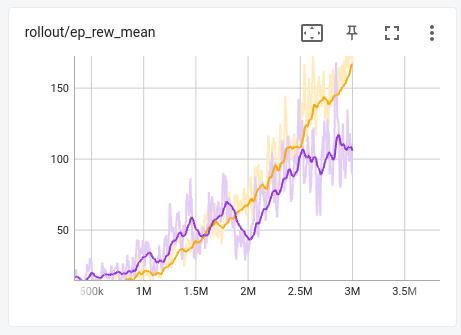

Now let's compare this with the new map-based observation space:

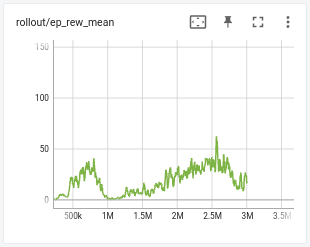

So far, the performance is significantly worse. Parameter tuning may be needed.

# Tuning hyperparameters

To optimize the hyperparameters, [Optuna](https://optuna.org/) will be used. To use Optuna we need three things:

- An objective to optimize. The evaluation mean reward in this case.
- A way to monitored the objective. The objetive is monitored while the Agent is being trained.
- A way to sample from the hyperparameters and choose the optimal ones.

These three pieces will be built on the next cell.

In [ ]:
# import optuna
# from optuna.pruners import MedianPruner
# from optuna.samplers import TPESampler

# from sb3_contrib import MaskablePPO
# from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy

# ### Clean previous training model and envs ###

# try:
#     model.env.close()
#     eval_env.close()
#     env.close()
# except Exception:
#     pass

# ### Global configuration variables ###
# rollout_steps = 4000
# env_id = 'LuxAI_S2-v0'
# log_path = "logs/exp_mppo"
# n_envs = 4

# total_timesteps = 300_000

# eval_max_episode_steps=1000
# eval_freq=24_000

# invalid_action_masking=True

# n_trials=10 # Optuna will use 10 trials
# n_startup_trials=3 # Optuna will not use pruning or non-random sampling during these trials

# n_evaluations = int(total_timesteps / eval_freq)  # Number of evaluations per train

# class TrialEvalCallback(EvalCallback):
#     """Monitor the mean eval reward so Optuna can optimize the hyperparameters."""
#     def __init__(
#         self,
#         eval_env: gym.Env,
#         trial: optuna.Trial,
#         n_eval_episodes: int = 5,
#         eval_freq: int = 10000,
#         deterministic: bool = True,
#         verbose: int = 0,
#     ):
#         super().__init__(
#             eval_env=eval_env,
#             n_eval_episodes=n_eval_episodes,
#             eval_freq=eval_freq,
#             deterministic=deterministic,
#             verbose=verbose,
#         )
#         self.trial = trial
#         self.eval_idx = 0
#         self.is_pruned = False

#     def _on_step(self) -> bool:
#         if self.eval_freq > 0 and self.n_calls % self.eval_freq == 0:
#             super()._on_step()
#             self.eval_idx += 1
#             self.trial.report(self.last_mean_reward, self.eval_idx)
#             if self.trial.should_prune():
#                 self.is_pruned = True
#                 return False
#         return True

# def sample_ppo_parameters(trial: optuna.Trial):
#     """Get PPO parameters. Some suggested by Optuna based on Trials."""
#     batch_size = 800

#     learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-03, log=True)

#     n_epochs = trial.suggest_int("n_epochs", 2, 3)

#     max_episode_steps = trial.suggest_int("max_episode_steps", 200, 1000)

#     target_kl = 0.05

#     gamma = 0.99

#     output_paramaters = dict(
#         learning_rate=learning_rate,
#         n_epochs=n_epochs,
#         max_episode_steps=max_episode_steps,
#         target_kl=target_kl,
#         gamma=gamma,
#         batch_size=batch_size,
#     )

#     return output_paramaters

# def objective(trial: optuna.Trial) -> float:
#     """Set the objective for optuna to optimize.
    
#     Notes
#     -----
#     In this case, the mean evaluation reward of the agent is optimized.
    
#     """
#     set_random_seed(0)

#     policy_kwargs = dict(
#         features_extractor_class=NatureCNN,
#         features_extractor_kwargs=dict(features_dim=128),
#         net_arch=(64, 64),
#     )

#     ppo_parameters = sample_ppo_parameters(trial)

#     max_episode_steps = ppo_parameters.pop("max_episode_steps")

#     environments = [make_env(env_id, i, max_episode_steps=max_episode_steps) for i in range(n_envs)]
#     env = DummyVecEnv(environments) if invalid_action_masking else SubprocVecEnv(environments)
#     env.reset()

#     model = MaskablePPO(
#         "CnnPolicy",
#         env,
#         n_steps=rollout_steps // n_envs,
#         policy_kwargs=policy_kwargs,
#         verbose=1,
#         tensorboard_log=osp.join(log_path),
#         **ppo_parameters,
#     )

#     eval_environments = [make_env(env_id, i, max_episode_steps=eval_max_episode_steps) for i in range(4)]
#     eval_env = DummyVecEnv(eval_environments) if invalid_action_masking else SubprocVecEnv(eval_environments)
#     eval_env.reset()

#     eval_callback = TrialEvalCallback(
#         eval_env,
#         trial=trial,
#         eval_freq=eval_freq,
#         deterministic=False,
#         n_eval_episodes=5,
#     )

#     try:
#         model.learn(
#             total_timesteps,
#             callback=[TensorboardCallback(tag="train_metrics"), eval_callback],
#         )
#     finally:
#         # Free memory.
#         model.env.close()
#         eval_env.close()
#         env.close()

#     return eval_callback.last_mean_reward

In [ ]:
# sampler = TPESampler(n_startup_trials=n_startup_trials)

# # Do not prune before 1/3 of the max budget is used
# pruner = MedianPruner(
#     n_startup_trials=n_startup_trials,
#     n_warmup_steps=n_evaluations // 3
# )

# # Create the study and start the hyperparameter optimization
# study = optuna.create_study(
#     sampler=sampler, pruner=pruner, direction="maximize"
# )

# study.optimize(
#     objective,
#     n_trials=n_trials,
#     n_jobs=1,
#     timeout=None
# )

## Packaging and Submission

We now have a trained policy. In order to make it submittable to the competition we recommend you write code on separate files and only use kaggle notebooks for training as it can get very messy to program an RL agent just using a Kaggle notebook interface. The starter kit that was downloaded earlier has all of the code above written already and organized into separate files and folders. The observation wrapper and controller written here are saved to the `wrappers` folder. The SB3Wrapper is not in the kit, but is a part of the official luxai_s2 package and you can import it with

```
from luxai_s2.wrappers import SB3Wrapper
```

The main file to take note of is `agent.py` which defines your agent's behavior. It will load the policy from`MODEL_WEIGHTS_RELATIVE_PATH` which can be changed at the top of `agent.py`.

`agent.py` also uses the actions_mask function to invalidate some actions so that the policy only generates valid actions, which is a easy way to improve performance.

In [ ]:
def animate(imgs, _return=True):
    # using cv2 to generate videos as moviepy doesn't work on kaggle notebooks
    import cv2
    import os
    import string
    import random
    video_name = ''.join(random.choice(string.ascii_letters) for i in range(18))+'.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width,height))

    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()
    if _return:
        from IPython.display import Video
        return Video(video_name)
def interact(env, agents, steps):
    # reset our env
    obs = env.reset(seed=41)
    np.random.seed(0)
    imgs = []
    step = 0
    # Note that as the environment has two phases, we also keep track a value called 
    # `real_env_steps` in the environment state. The first phase ends once `real_env_steps` is 0 and used below

    # iterate until phase 1 ends
    while env.state.real_env_steps < 0:
        if step >= steps: break
        actions = {}
        for player in env.agents:
            o = obs[player]
            if step == 0:
                a = agents[player].bid_policy(step, o)
            else:
                a = agents[player].factory_placement_policy(step, o)
            actions[player] = a
        step += 1
        obs, rewards, dones, infos = env.step(actions)
        imgs += [env.render("rgb_array", width=640, height=640)]
    done = False
    while not done:
        if step >= steps: break
        stats: StatsStateDict = env.state.stats
#         print(stats)
        actions = {}
        for player in env.agents:
            o = obs[player]
            a = agents[player].act(step, o)
            actions[player] = a
        step += 1
        obs, rewards, dones, infos = env.step(actions)
#         print(rewards, dones, infos)
        imgs += [env.render("rgb_array", width=640, height=640)]
        done = dones["player_0"] and dones["player_1"]
    return animate(imgs)

In [ ]:
# %%writefile agent.py
"""
This file is where your agent's logic is kept. Define a bidding policy, factory placement policy, 
as well as a policy for playing the normal phase of the game

The tutorial will learn an RL agent to play the normal phase and use heuristics for the other two phases.

Note that like the other kits, you can only debug print to standard error e.g. print("message", file=sys.stderr)
"""

import os.path as osp
import sys
import numpy as np
import torch as th
from stable_baselines3.ppo import PPO
from lux.config import EnvConfig
# from wrappers import SimpleUnitDiscreteController, SimpleUnitObservationWrapper

# change this to use weights stored elsewhere
# make sure the model weights are submitted with the other code files
# any files in the logs folder are not necessary. Make sure to exclude the .zip extension here
MODEL_WEIGHTS_RELATIVE_PATH = "./logs/action_map/models/best_model.zip"
if not os.path.isfile(MODEL_WEIGHTS_RELATIVE_PATH):
    print('latest')
    MODEL_WEIGHTS_RELATIVE_PATH = "./logs/action_map/models/latest_model"
else:
    print('best')
    

class Agent:
    def __init__(self, player: str, env_cfg: EnvConfig) -> None:
        self.player = player
        self.opp_player = "player_1" if self.player == "player_0" else "player_0"
        np.random.seed(0)
        self.env_cfg: EnvConfig = env_cfg

#         directory = osp.dirname(__file__)
#         self.policy = PPO.load(osp.join(directory, MODEL_WEIGHTS_RELATIVE_PATH))
        self.policy = PPO.load(MODEL_WEIGHTS_RELATIVE_PATH)
#         print(self.policy.policy)

        self.controller = SimpleUnitDiscreteController(self.env_cfg)

    def bid_policy(self, step: int, obs, remainingOverageTime: int = 60):
        # the policy here is the same one used in the RL tutorial: https://www.kaggle.com/code/stonet2000/rl-with-lux-2-rl-problem-solving
        return dict(faction="AlphaStrike", bid=0)

    def factory_placement_policy(self, step: int, obs, remainingOverageTime: int = 60):
        # the policy here is the same one used in the RL tutorial: https://www.kaggle.com/code/stonet2000/rl-with-lux-2-rl-problem-solving
        if obs["teams"][self.player]["metal"] == 0:
            return dict()
        potential_spawns = list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1)))
        potential_spawns_set = set(potential_spawns)
        done_search = False

        ice_diff = np.diff(obs["board"]["ice"])
        pot_ice_spots = np.argwhere(ice_diff == 1)
        if len(pot_ice_spots) == 0:
            pot_ice_spots = potential_spawns
        trials = 5
        while trials > 0:
            pos_idx = np.random.randint(0, len(pot_ice_spots))
            pos = pot_ice_spots[pos_idx]

            area = 3
            for x in range(area):
                for y in range(area):
                    check_pos = [pos[0] + x - area // 2, pos[1] + y - area // 2]
                    if tuple(check_pos) in potential_spawns_set:
                        done_search = True
                        pos = check_pos
                        break
                if done_search:
                    break
            if done_search:
                break
            trials -= 1
        spawn_loc = potential_spawns[np.random.randint(0, len(potential_spawns))]
        if not done_search:
            pos = spawn_loc

        metal = obs["teams"][self.player]["metal"]
        return dict(spawn=pos, metal=100, water=100)

    def act(self, step: int, obs, remainingOverageTime: int = 60):
        # first convert observations using the same observation wrapper you used for training
        # note that SimpleUnitObservationWrapper takes input as the full observation for both players and returns an obs for players
        raw_obs = dict(player_0=obs, player_1=obs)
        obs = RTSObservationWrapper.convert_obs(raw_obs, env_cfg=self.env_cfg)
        obs = obs[self.player]
        factories = raw_obs[self.player]['factories']
        for player in factories.keys():
            for id, factory in factories[player].items():
                print('step',step, id, factory['cargo'])

        obs = th.from_numpy(obs).float()
        with th.no_grad():

            # to improve performance, we have a rule based action mask generator for the controller used
            # which will force the agent to generate actions that are valid only.
            action_mask = (
                th.from_numpy(self.controller.action_masks(self.player, raw_obs))
                .unsqueeze(0)
                .bool()
            )
            
            # SB3 doesn't support invalid action masking. So we do it ourselves here
            features = self.policy.policy.features_extractor(obs.unsqueeze(0))
            x = self.policy.policy.mlp_extractor.policy_net(features)
            logits = self.policy.policy.action_net(x) # shape (1, N) where N=12 for the default controller
            logits[action_mask==False] = -1e8 # mask out invalid actions
            logits = logits.reshape(2,12)
#             print(logits)
            dist = th.distributions.Categorical(logits=logits)
            actions = dist.sample().cpu().numpy() # shape (1, 1)
#             print(actions)

        # use our controller which we trained with in train.py to generate a Lux S2 compatible action
        lux_action = self.controller.action_to_lux_action(
            self.player, raw_obs, actions
        )

        # commented code below adds watering lichen which can easily improve your agent
        # shared_obs = raw_obs[self.player]
        # factories = shared_obs["factories"][self.player]
        # for unit_id in factories.keys():
        #     factory = factories[unit_id]
        #     if 1000 - step < 50 and factory["cargo"]["water"] > 100:
        #         lux_action[unit_id] = 2 # water and grow lichen at the very end of the game

        return lux_action

In [ ]:
# recreate our agents and run
env = LuxAI_S2()
obs = env.reset(seed=41)
agents = {player: Agent(player, env.state.env_cfg) for player in env.agents}
interact(env, agents, steps=100)

In [ ]:
# !luxai-s2 main.py main.py -v 2 -s 101 -o replay.html

In [ ]:
# import IPython # load the HTML replay
# IPython.display.HTML(filename='replay.html')